In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
(xfull,yfull),(xtest,ytest)=keras.datasets.fashion_mnist.load_data()
xvalid,xtrain=xfull[:5000],xfull[5000:]
yvalid,ytrain=yfull[:5000],yfull[5000:]
validset=tf.data.Dataset.from_tensor_slices((xvalid,yvalid))
trainset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).shuffle(len(xtrain))
testset=tf.data.Dataset.from_tensor_slices((xtest,ytest))

In [3]:
from tensorflow.train import Feature,Features,Example,BytesList,Int64List
def createexam(image,label):
    imagedata=tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                'image':Feature(bytes_list=BytesList(value=[imagedata.numpy()])),
                'label':Feature(int64_list=Int64List(value=[label])),
            }
        )
    )
for image,label in validset.take(1):
    print(createexam(image,int(label)))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [4]:
from contextlib import ExitStack

def writetfrecode(name,dataset,n_shards=10):
    paths=['{}.tfrecord-{:05d}-of-{:05d}'.format(name,index,n_shards)
         for index in range(n_shards)]
    with ExitStack() as stack:
        writers=[stack.enter_context(tf.io.TFRecordWriter(path))
                for path in paths]
        for index,(image,label)in dataset.enumerate():
            shard=index%n_shards
            example=createexam(image,int(label))
            writers[shard].write(example.SerializeToString())
    return paths
        

In [5]:
trainpath=writetfrecode('myfac.train',trainset)
validpath=writetfrecode('myfac.valid',validset)
testpath=writetfrecode('myfac.test',testset)

In [7]:
def preprocess(tfrecord):
    feature_desc={
        'image':tf.io.FixedLenFeature([],tf.string,default_value=''),
        'label':tf.io.FixedLenFeature([],tf.int64,default_value=-1)
    }
    example=tf.io.parse_single_example(tfrecord,feature_desc)
    image=tf.io.parse_tensor(example['image'],out_type=tf.uint8)
    image=tf.reshape(image,shape=[28,28])
    return image,example['label']

def mnistdataset(filepath,n_read_threads=5,shuffle_buffer_size=None,n_parse_threads=5,batch_size=32,
                 cache=True  ):
    dataset=tf.data.TFRecordDataset(filepath,num_parallel_reads=n_read_threads)
    if cache:
        dataset=dataset.cache()
    if shuffle_buffer_size:
        dataset=dataset.shuffle(shuffle_buffer_size)
    dataset=dataset.map(preprocess,num_parallel_calls=n_parse_threads)
    dataset=dataset.batch(batch_size)
    return dataset.prefetch(1)

In [11]:
trainset=mnistdataset(trainpath,shuffle_buffer_size=60000)
validset=mnistdataset(validpath)
testset=mnistdataset(testpath)


AttributeError: module 'tensorflow.keras.layers' has no attribute 'Normalization'

In [18]:
import numpy as np
class Standardization(keras.layers.Layer):
    def adapt(self,data_sample):
        self.means_=np.mean(data_sample,axis=0,keepdims=True)
        self.stds=np.std(data_sample,axis=0,keepdims=True)
    def call(self,inputs):
        return (inputs-self.means_)/(self.stds+keras.backend.epsilon())
stand=Standardization(input_shape=[28,28])

samplebatch=trainset.take(100).map(lambda image,label:image)
sampleimage=np.concatenate(list(samplebatch.as_numpy_iterator()),axis=0).astype(np.float32)

stand.adapt(sampleimage)

model=keras.models.Sequential([
    stand,
    keras.layers.Flatten(),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
    
])
    
model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

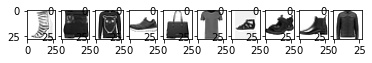

In [17]:
import matplotlib.pyplot as plt
for x,y in trainset.take(1):
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].numpy(),cmap='binary')

In [21]:
from datetime import datetime
import os
logs=os.path.join(os.curdir,'mylogs','run'+datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard=tf.keras.callbacks.TensorBoard(
log_dir=logs,histogram_freq=1,profile_batch=10)

model.fit(trainset,epochs=5,validation_data=validset,callbacks=[tensorboard])

Epoch 1/5
1719/1719 [==============================] - 14s 7ms/step - loss: 0.5636 - accuracy: 0.8038 - val_loss: 0.3715 - val_accuracy: 0.8690
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3421 - accuracy: 0.8780 - val_loss: 0.3512 - val_accuracy: 0.8778
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2920 - accuracy: 0.8937 - val_loss: 0.3491 - val_accuracy: 0.8840
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2707 - accuracy: 0.8984 - val_loss: 0.3445 - val_accuracy: 0.8840
Epoch 5/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2457 - accuracy: 0.9105 - val_loss: 0.3474 - val_accuracy: 0.8880


In [22]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Launching TensorBoard...

KeyboardInterrupt: 